# **10.BONUS. PRECOMPUTING FREQUENCY TENSOR**

Some data and charts in the [10. RoPE (ROTARY POSITIONAL EMBEDDINGS)](./10-ROPE-ROTARY-POSITIONAL-EMBEDDINGS.md) chapter of the documentation were generated by using this notebook.

## **10.BONUS.1. Initiating Angles of Frequency Tensor**

In [5]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product


# Modified to get additional variables
# See: https://github.com/meta-llama/llama-models/blob/f45cdfd624b98b6655540f7101d8d9cb432e631c/models/llama3_1/reference_impl/model.py#L45

def apply_scaling(freqs: torch.Tensor):
    # Values obtained from grid search
    scale_factor = 8
    low_freq_factor = 1
    high_freq_factor = 4
    old_context_len = 8192  # original llama3 length

    low_freq_wavelen = old_context_len / low_freq_factor
    high_freq_wavelen = old_context_len / high_freq_factor
    new_freqs = []
    for freq in freqs:
        wavelen = 2 * math.pi / freq
        if wavelen < high_freq_wavelen:
            new_freqs.append(freq)
        elif wavelen > low_freq_wavelen:
            new_freqs.append(freq / scale_factor)
        else:
            assert low_freq_wavelen != high_freq_wavelen
            smooth = (old_context_len / wavelen - low_freq_factor) / (
                high_freq_factor - low_freq_factor
            )
            new_freqs.append((1 - smooth) * freq / scale_factor + smooth * freq)
    return torch.tensor(new_freqs, dtype=freqs.dtype, device=freqs.device)


def precompute_freqs_cis(
    dim: int, end: int, theta: float = 10000.0, use_scaled: bool = False
):
    """
    The code comment [from the original Llama 2 Python code](https://github.com/facebookresearch/llama/blob/ef351e9cd9496c579bf9f2bb036ef11bdc5ca3d2/llama/model.py#L80) that explains this:

    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.




    """
    vals = torch.arange(0, dim, 2)[: (dim // 2)]
    freqs = 1.0 / (theta ** (vals.float() / dim))
    if use_scaled:
        freqs = apply_scaling(freqs)
    backup_angles = freqs
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs).float()  # type: ignore
    backup_freqs = freqs
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis, vals, backup_angles, backup_freqs


freqs_cis_orig, vals, backup_angles, backup_freqs = precompute_freqs_cis(128, 4096, theta=500000, use_scaled=True)
deg_angles = np.rad2deg(backup_angles)
deg_freqs = np.rad2deg(backup_freqs)

Printing the base angles of the frequency tensor

In [10]:
# This cell prints the 64 angles which are the base for the frequency tensor.
# Then I gave this list as input to ChatGPT and requested to convert it to a Markdown table existing in the documentation.

torch.set_printoptions(sci_mode=False, precision=5)
freq_zip = zip(vals, backup_angles, deg_angles)
for val, rad, deg in freq_zip:
  print(f"val: {val}, rad: {rad:.8f}, deg: {deg:.5f}")

val: 0, rad: 1.00000000, deg: 57.29578
val: 2, rad: 0.81461722, deg: 46.67413
val: 4, rad: 0.66360128, deg: 38.02155
val: 6, rad: 0.54058099, deg: 30.97301
val: 8, rad: 0.44036663, deg: 25.23115
val: 10, rad: 0.35873023, deg: 20.55373
val: 12, rad: 0.29222783, deg: 16.74342
val: 14, rad: 0.23805381, deg: 13.63948
val: 16, rad: 0.19392276, deg: 11.11096
val: 18, rad: 0.15797281, deg: 9.05118
val: 20, rad: 0.12868738, deg: 7.37324
val: 22, rad: 0.10483095, deg: 6.00637
val: 24, rad: 0.08539710, deg: 4.89289
val: 26, rad: 0.06956595, deg: 3.98584
val: 28, rad: 0.05666962, deg: 3.24693
val: 30, rad: 0.04616405, deg: 2.64501
val: 32, rad: 0.03760603, deg: 2.15467
val: 34, rad: 0.03063452, deg: 1.75523
val: 36, rad: 0.02495541, deg: 1.42984
val: 38, rad: 0.02032910, deg: 1.16477
val: 40, rad: 0.01656044, deg: 0.94884
val: 42, rad: 0.01349042, deg: 0.77294
val: 44, rad: 0.01098953, deg: 0.62965
val: 46, rad: 0.00895226, deg: 0.51293
val: 48, rad: 0.00729267, deg: 0.41784
val: 50, rad: 0.00594

This is the output of Python + Pytorch environment. There are slight differences between them because of floating point precision differences.

In the table below, you can find approximate equivalents of radian angle values in degrees, with corresponding "val" indices:

| **val** | **rad**       | **deg**   |     | **val** | **rad**       | **deg**   |     | **val** | **rad**       | **deg**   |     | **val** | **rad**       | **deg**   |
|---------|---------------|-----------|-----|---------|---------------|-----------|-----|---------|---------------|-----------|-----|---------|---------------|-----------|
| **0**   | 1.00000000    | 57.29578  |     | **32**  | 0.03760603    | 2.15467   |     | **64**  | 0.00052485    | 0.03007   |     | **96**  | 0.00000665    | 0.00038   |
| **2**   | 0.81461722    | 46.67413  |     | **34**  | 0.03063452    | 1.75523   |     | **66**  | 0.00031269    | 0.01792   |     | **98**  | 0.00000542    | 0.00031   |
| **4**   | 0.66360128    | 38.02155  |     | **36**  | 0.02495541    | 1.42984   |     | **68**  | 0.00017851    | 0.01023   |     | **100** | 0.00000441    | 0.00025   |
| **6**   | 0.54058099    | 30.97301  |     | **38**  | 0.02032910    | 1.16477   |     | **70**  | 0.00009556    | 0.00548   |     | **102** | 0.00000359    | 0.00021   |
| **8**   | 0.44036663    | 25.23115  |     | **40**  | 0.01656044    | 0.94884   |     | **72**  | 0.00007785    | 0.00446   |     | **104** | 0.00000293    | 0.00017   |
| **10**  | 0.35873023    | 20.55373  |     | **42**  | 0.01349042    | 0.77294   |     | **74**  | 0.00006342    | 0.00363   |     | **106** | 0.00000238    | 0.00014   |
| **12**  | 0.29222783    | 16.74342  |     | **44**  | 0.01098953    | 0.62965   |     | **76**  | 0.00005166    | 0.00296   |     | **108** | 0.00000194    | 0.00011   |
| **14**  | 0.23805381    | 13.63948  |     | **46**  | 0.00895226    | 0.51293   |     | **78**  | 0.00004208    | 0.00241   |     | **110** | 0.00000158    | 0.00009   |
| **16**  | 0.19392276    | 11.11096  |     | **48**  | 0.00729267    | 0.41784   |     | **80**  | 0.00003428    | 0.00196   |     | **112** | 0.00000129    | 0.00007   |
| **18**  | 0.15797281    | 9.05118   |     | **50**  | 0.00594073    | 0.34038   |     | **82**  | 0.00002793    | 0.00160   |     | **114** | 0.00000105    | 0.00006   |
| **20**  | 0.12868738    | 7.37324   |     | **52**  | 0.00483942    | 0.27728   |     | **84**  | 0.00002275    | 0.00130   |     | **116** | 0.00000086    | 0.00005   |
| **22**  | 0.10483095    | 6.00637   |     | **54**  | 0.00394228    | 0.22588   |     | **86**  | 0.00001853    | 0.00106   |     | **118** | 0.00000070    | 0.00004   |
| **24**  | 0.08539710    | 4.89289   |     | **56**  | 0.00321145    | 0.18400   |     | **88**  | 0.00001510    | 0.00086   |     | **120** | 0.00000057    | 0.00003   |
| **26**  | 0.06956595    | 3.98584   |     | **58**  | 0.00216657    | 0.12414   |     | **90**  | 0.00001230    | 0.00070   |     | **122** | 0.00000046    | 0.00003   |
| **28**  | 0.05666962    | 3.24693   |     | **60**  | 0.00137189    | 0.07860   |     | **92**  | 0.00001002    | 0.00057   |     | **124** | 0.00000038    | 0.00002   |
| **30**  | 0.04616405    | 2.64501   |     | **62**  | 0.00085675    | 0.04909   |     | **94**  | 0.00000816    | 0.00047   |     | **126** | 0.00000031    | 0.00002   |

## **10.BONUS.2. Getting Outer Product of Frequency Tensor and Position Indices**

Printing some samples from freqs_cis_orig for the documentation, angles in degrees.

In [14]:
sample_indices = [
    [0, 0], [0, 1],
    [1, 0], [1, 1], [1, 62], [1, 63],
    [2, 0], [2, 1], [2, 62], [2, 63],
    [4094, 0], [4094, 1], [4094, 62], [4094, 63],
    [4095, 0], [4095, 1], [4095, 62], [4095, 63]
  ]
sample_indices_tensor = torch.tensor(sample_indices)

sample_backup_freqs = backup_freqs[sample_indices_tensor[:, 0], sample_indices_tensor[:, 1]].tolist()
sample_deg_freqs = deg_freqs[sample_indices_tensor[:, 0], sample_indices_tensor[:, 1]].tolist()

sample_deg_freqs_normalized = [angle % 360 for angle in sample_deg_freqs]
sample_deg_freqs_normalized = [angle if angle<=180 else angle-360 for angle in sample_deg_freqs_normalized]


samples_zip = zip(sample_indices, sample_backup_freqs, sample_deg_freqs, sample_deg_freqs_normalized)

for idx, rad, deg, deg_normalized in samples_zip:
  print(f"idx: {idx}, rad: {rad:.8f}, deg: {deg:.5f}, deg_normalized: {deg_normalized:.5f}")

idx: [0, 0], rad: 0.00000000, deg: 0.00000, deg_normalized: 0.00000
idx: [0, 1], rad: 0.00000000, deg: 0.00000, deg_normalized: 0.00000
idx: [1, 0], rad: 1.00000000, deg: 57.29578, deg_normalized: 57.29578
idx: [1, 1], rad: 0.81461722, deg: 46.67413, deg_normalized: 46.67413
idx: [1, 62], rad: 0.00000038, deg: 0.00002, deg_normalized: 0.00002
idx: [1, 63], rad: 0.00000031, deg: 0.00002, deg_normalized: 0.00002
idx: [2, 0], rad: 2.00000000, deg: 114.59155, deg_normalized: 114.59155
idx: [2, 1], rad: 1.62923443, deg: 93.34825, deg_normalized: 93.34825
idx: [2, 62], rad: 0.00000075, deg: 0.00004, deg_normalized: 0.00004
idx: [2, 63], rad: 0.00000061, deg: 0.00004, deg_normalized: 0.00004
idx: [4094, 0], rad: 4094.00000000, deg: 234568.90625, deg_normalized: -151.09375
idx: [4094, 1], rad: 3335.04296875, deg: 191083.87500, deg_normalized: -76.12500
idx: [4094, 62], rad: 0.00154234, deg: 0.08837, deg_normalized: 0.08837
idx: [4094, 63], rad: 0.00125642, deg: 0.07199, deg_normalized: 0.07199

## **10.BONUS.3. Visualized Form of Some Samples from The Frequency Tensor**


Taking some samples from already calculated angles and polar coordinates, then drawing some charts from these samples. These charts are drawn to make it easy for you to compare changes between positions and dimensions.

These functions will draw different types of charts here and also save them as .svg file.

Drawing 2D charts of angles:

In [15]:
fontsize_figure_title = 36
fontsize_ax_title = 24
fontsize_tick_label = 20
fontsize_annotation = 18

def prepare_index_list(source_list):
  result = set()
  for sublist in source_list:
    row_indices = list(range(sublist[0][0], sublist[0][1]))
    col_indices = list(range(sublist[1][0], sublist[1][1]))
    result = result.union(set([tuple(pair) for pair in product(row_indices, col_indices)]))
  result = sorted(result)
  position_indices = sorted(set([sample_index[0] for sample_index in result]))
  dim_indices = sorted(set([sample_index[1] for sample_index in result]))
  return result, position_indices, dim_indices

def check_overlapping_annotation(pos, existing_pos_list, tolerance = 0.07):
  for existing_pos in existing_pos_list:
    if abs(pos[1] - existing_pos[1]) <= tolerance:
      return True
  return False

def create_fig_multiple(title):
  fig, axs = plt.subplots(4, 2, figsize=(40, 80), subplot_kw={'aspect': 'equal'})
  fig.subplots_adjust(hspace=0.1, wspace=0.35, right=0.8)

  fig.set_facecolor('#FFFFFF')
  fig.suptitle(title, fontsize=fontsize_figure_title, y=axs[0,0].get_position().y1 + 0.02, verticalalignment="bottom")
  return fig, axs

def save_fig(fig, filename_suffix):
  fig.savefig(f'chart_{filename_suffix}.svg', format='svg', bbox_inches='tight', pad_inches=0.5)

def draw_2d_chart_ax(ax, title, colormap, sample_index_ranges, xlim = (-1.05, 1.05), ylim = (-1.05, 1.05)):
  sample_indices, position_indices, dim_indices = prepare_index_list(sample_index_ranges)
  freqs_cis_pairs = [(sample_index, freqs_cis_orig[sample_index[0], sample_index[1]]) for sample_index in sample_indices]
  freqs_cis_pairs = sorted(freqs_cis_pairs, key=lambda x: np.rad2deg(np.angle(x[1])))
  colors = colormap(torch.linspace(0, 1, len(dim_indices)))

  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2fj'))
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_facecolor('#F9F9F9')
  ax.tick_params(axis='both', labelsize=fontsize_tick_label)

  ax.axhline(0, color='black', linewidth=1.5)
  ax.axvline(0, color='black', linewidth=1.5)

  annotation_pos_list_negative = []
  annotation_pos_list_positive = []

  for sample_idx, freqs_cis_item in freqs_cis_pairs:
    position_idx, dim_idx = sample_idx
    color_idx = dim_indices.index(dim_idx)
    current_color = colors[color_idx]

    angle_rad = np.angle(freqs_cis_item)
    angle_rad_pi = angle_rad / np.pi
    angle_deg = np.rad2deg(angle_rad)

    r = freqs_cis_item.real.numpy()
    img = freqs_cis_item.imag.numpy()

    ax.plot((0, r), (0, img), color=current_color, linestyle='--')
    ax.plot((0, r), (0, img), 'o', color=current_color, markersize=5)

    annotation_text = f"dim_idx={sample_idx[1]}, dim={sample_idx[1]*2}, angle={angle_rad:.5f} rad ≈ {angle_rad_pi:.2f}π rad ≈ {angle_deg:.2f}°"
    annotation_pos = (r, img)
    offset_y = 0
    offset_sign = 1
    annotation_pos_list = annotation_pos_list_positive if annotation_pos[0] >= 0 else annotation_pos_list_negative
    if annotation_pos[0] < 0:
      annotation_pos = (max(xlim[0], annotation_pos[0] - 0.7), annotation_pos[1])
    elif annotation_pos[0] > 0:
      if xlim[0] < -0.1:
        annotation_pos = (max(0.05, annotation_pos[0] - 1), annotation_pos[1])
      else:
        annotation_pos = (max(xlim[0], annotation_pos[0] - 0.7), annotation_pos[1])

    if check_overlapping_annotation((annotation_pos[0], annotation_pos[1]), annotation_pos_list):
      while True:
        offset_y += 0.01
        if not check_overlapping_annotation((annotation_pos[0], annotation_pos[1] + offset_y), annotation_pos_list):
          offset_sign = 1
          break
        elif not check_overlapping_annotation((annotation_pos[0], annotation_pos[1] - offset_y), annotation_pos_list):
          offset_sign = -1
          break
    annotation_pos = (annotation_pos[0], annotation_pos[1] + offset_sign * offset_y)
    annotation_pos_list.append(annotation_pos)
    ax.annotate(annotation_text, annotation_pos, color=current_color, fontsize=fontsize_annotation, wrap=True)

    ax.set_xlabel('Real - cosθ', fontsize=fontsize_tick_label)
    ax.set_ylabel('Imaginary - sinθ', fontsize=fontsize_tick_label)

    ax.set_title(title, fontsize=fontsize_ax_title)
    ax.grid(True)


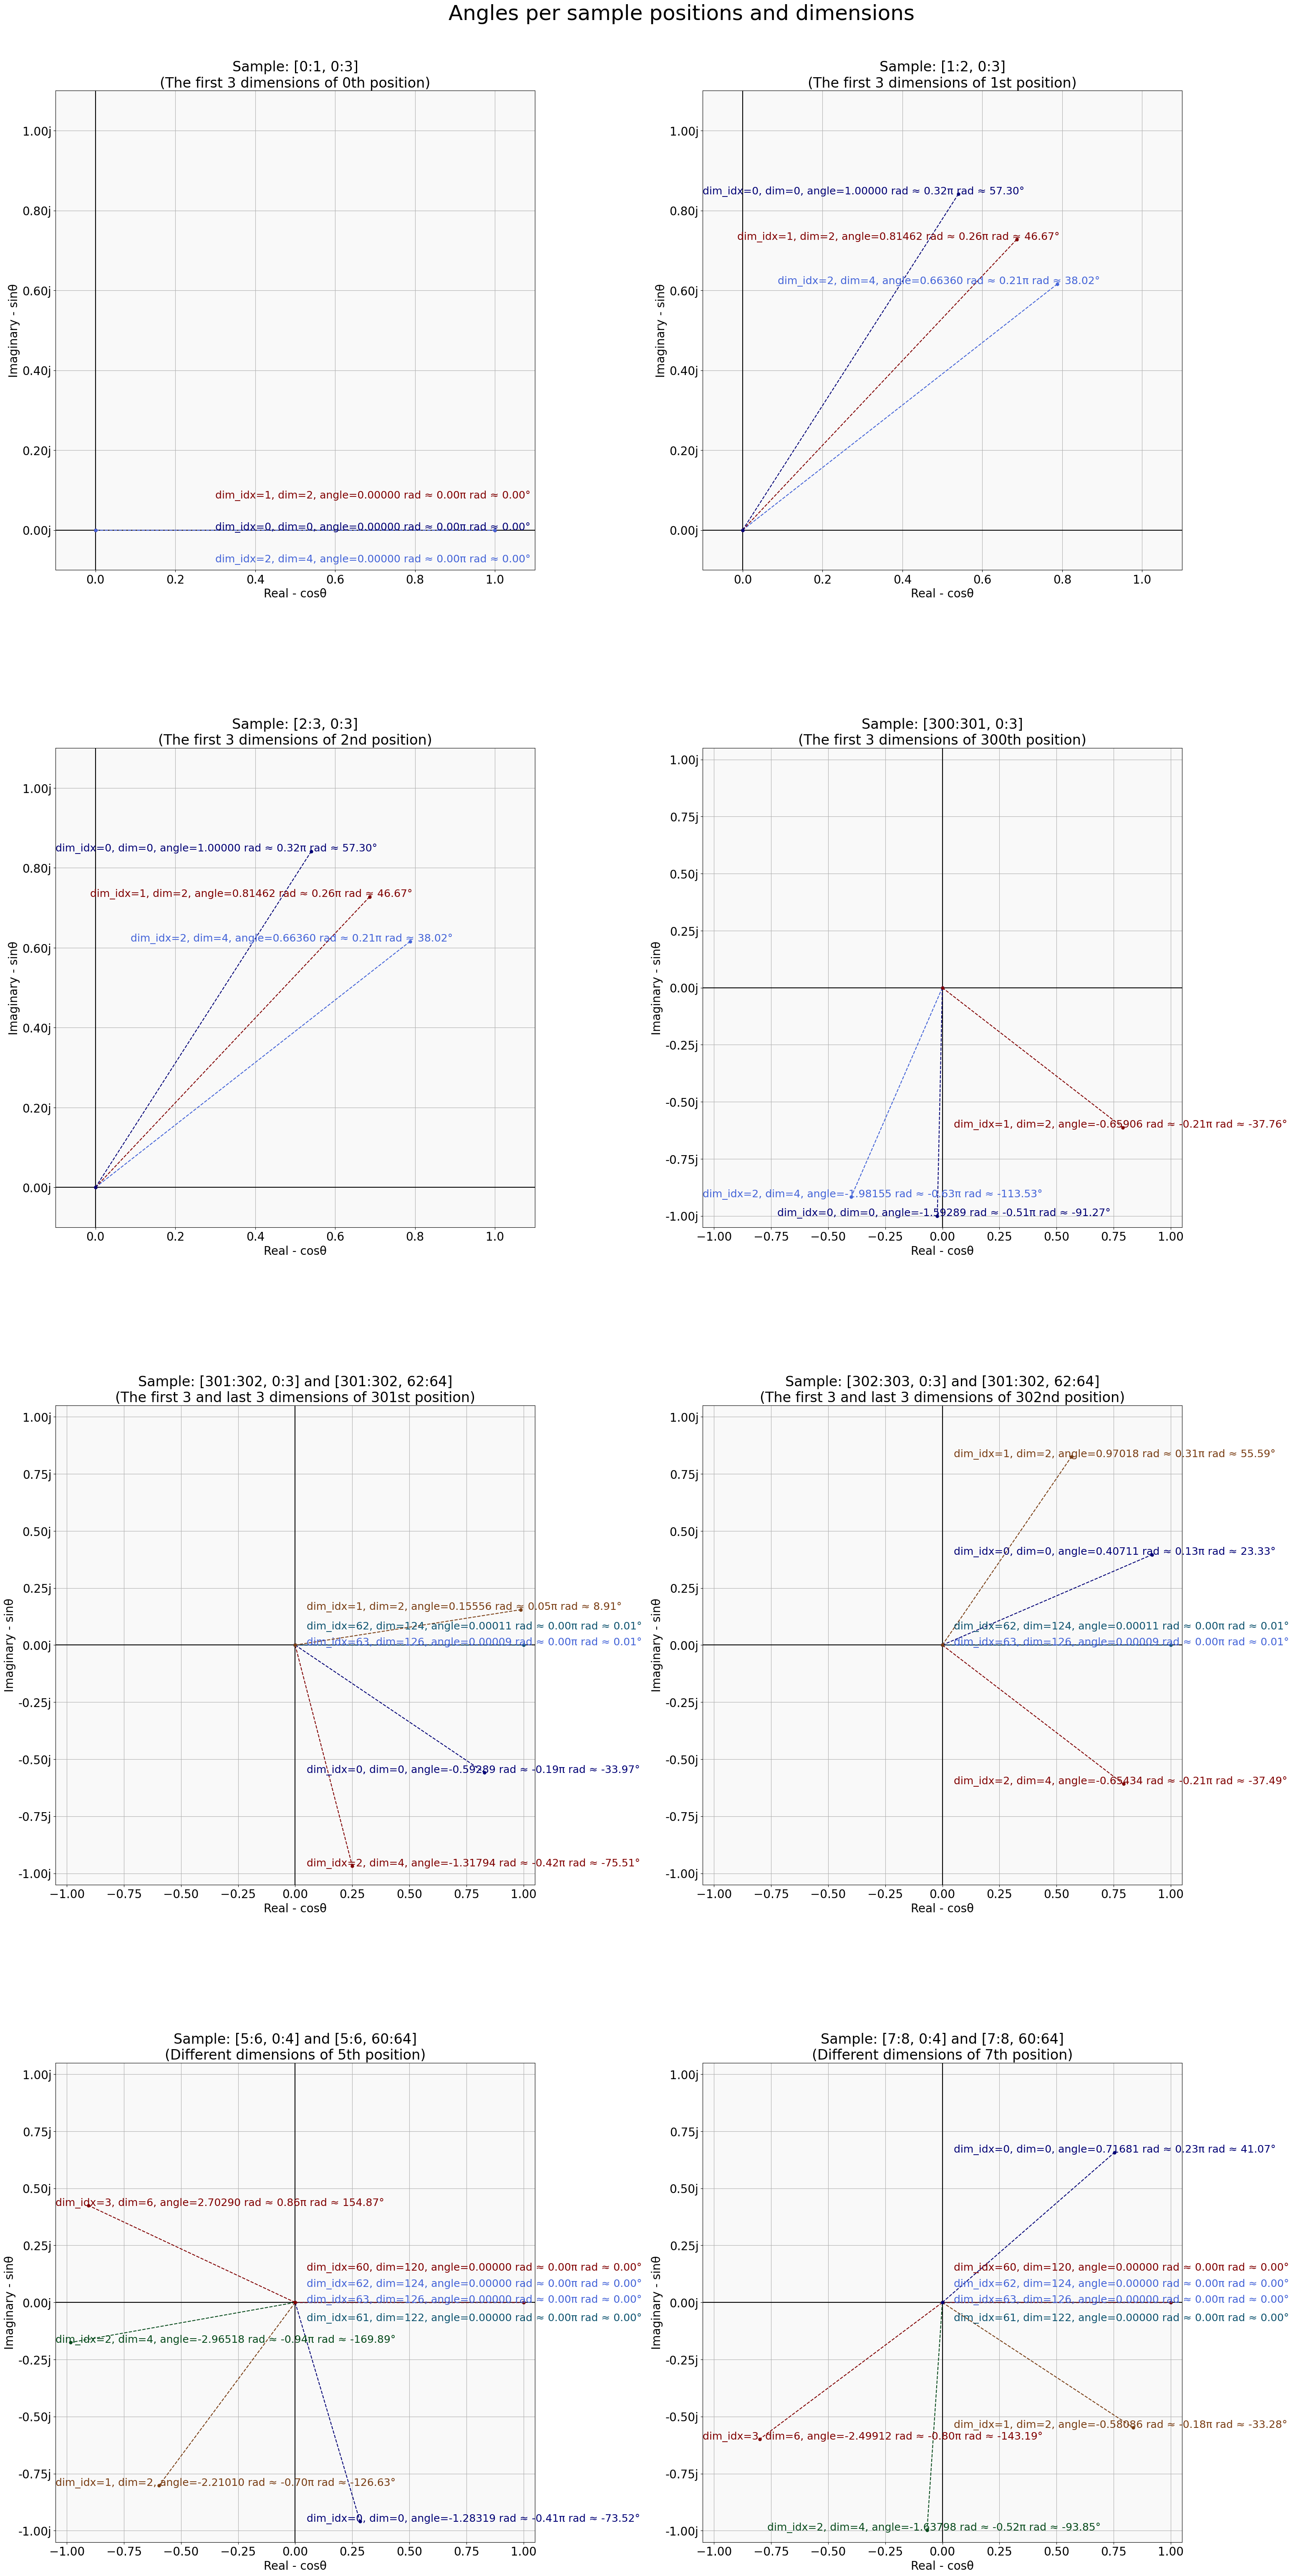

In [16]:
def draw_all_2d_charts():
  hex_colors = ['#000075', '#793D13', '#064A1B', '#800000', '#000000', '#0E536F', '#4363d8']
  rgb_colors = [to_rgb(color) for color in hex_colors]

  colormap = ListedColormap(rgb_colors)

  fig, axs = create_fig_multiple("Angles per sample positions and dimensions")

  draw_2d_chart_ax(axs[0, 0], "Sample: [0:1, 0:3]\n(The first 3 dimensions of 0th position)", colormap, [
      [(0,1), (0, 3)]
    ], xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

  draw_2d_chart_ax(axs[0, 1], "Sample: [1:2, 0:3]\n(The first 3 dimensions of 1st position)", colormap, [
      [(1,2), (0, 3)]
    ], xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

  draw_2d_chart_ax(axs[1, 0], "Sample: [2:3, 0:3]\n(The first 3 dimensions of 2nd position)", colormap, [
      [(1,2), (0, 3)]
    ], xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

  draw_2d_chart_ax(axs[1, 1], "Sample: [300:301, 0:3]\n(The first 3 dimensions of 300th position)", colormap, [
      [(300,301), (0, 3)]
    ])

  draw_2d_chart_ax(axs[2, 0], "Sample: [301:302, 0:3] and [301:302, 62:64]\n(The first 3 and last 3 dimensions of 301st position)", colormap, [
      [(301,302), (0, 3)],
      [(301,302), (62, 64)],
    ])

  draw_2d_chart_ax(axs[2, 1], "Sample: [302:303, 0:3] and [301:302, 62:64]\n(The first 3 and last 3 dimensions of 302nd position)", colormap, [
      [(302,303), (0, 3)],
      [(302,303), (62, 64)],
    ])

  draw_2d_chart_ax(axs[3, 0], "Sample: [5:6, 0:4] and [5:6, 60:64]\n(Different dimensions of 5th position)", colormap, [
      [(5,6), (0, 4)],
      [(5,6), (60, 64)],
    ])

  draw_2d_chart_ax(axs[3, 1], "Sample: [7:8, 0:4] and [7:8, 60:64]\n(Different dimensions of 7th position)", colormap, [
      [(7,8), (0, 4)],
      [(7,8), (60, 64)],
    ])

  save_fig(fig, "angles_2d")
  plt.show()


draw_all_2d_charts()

Drawing 3D charts of polar coordinates:

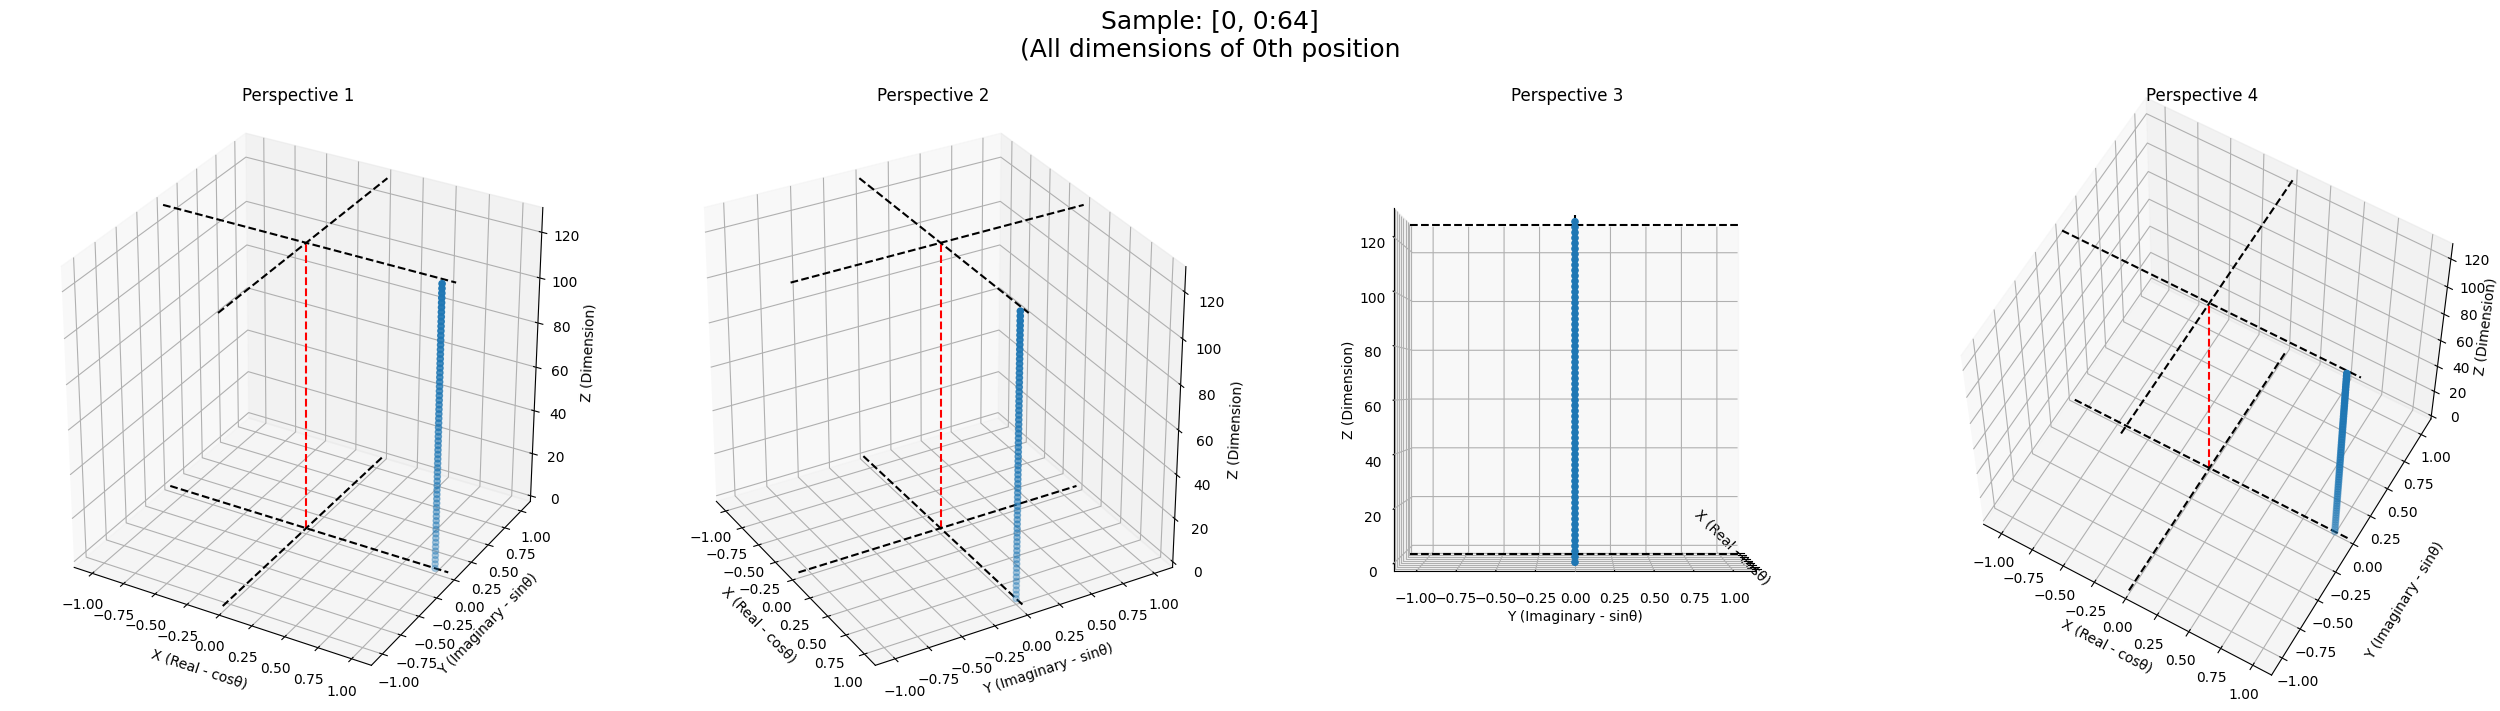

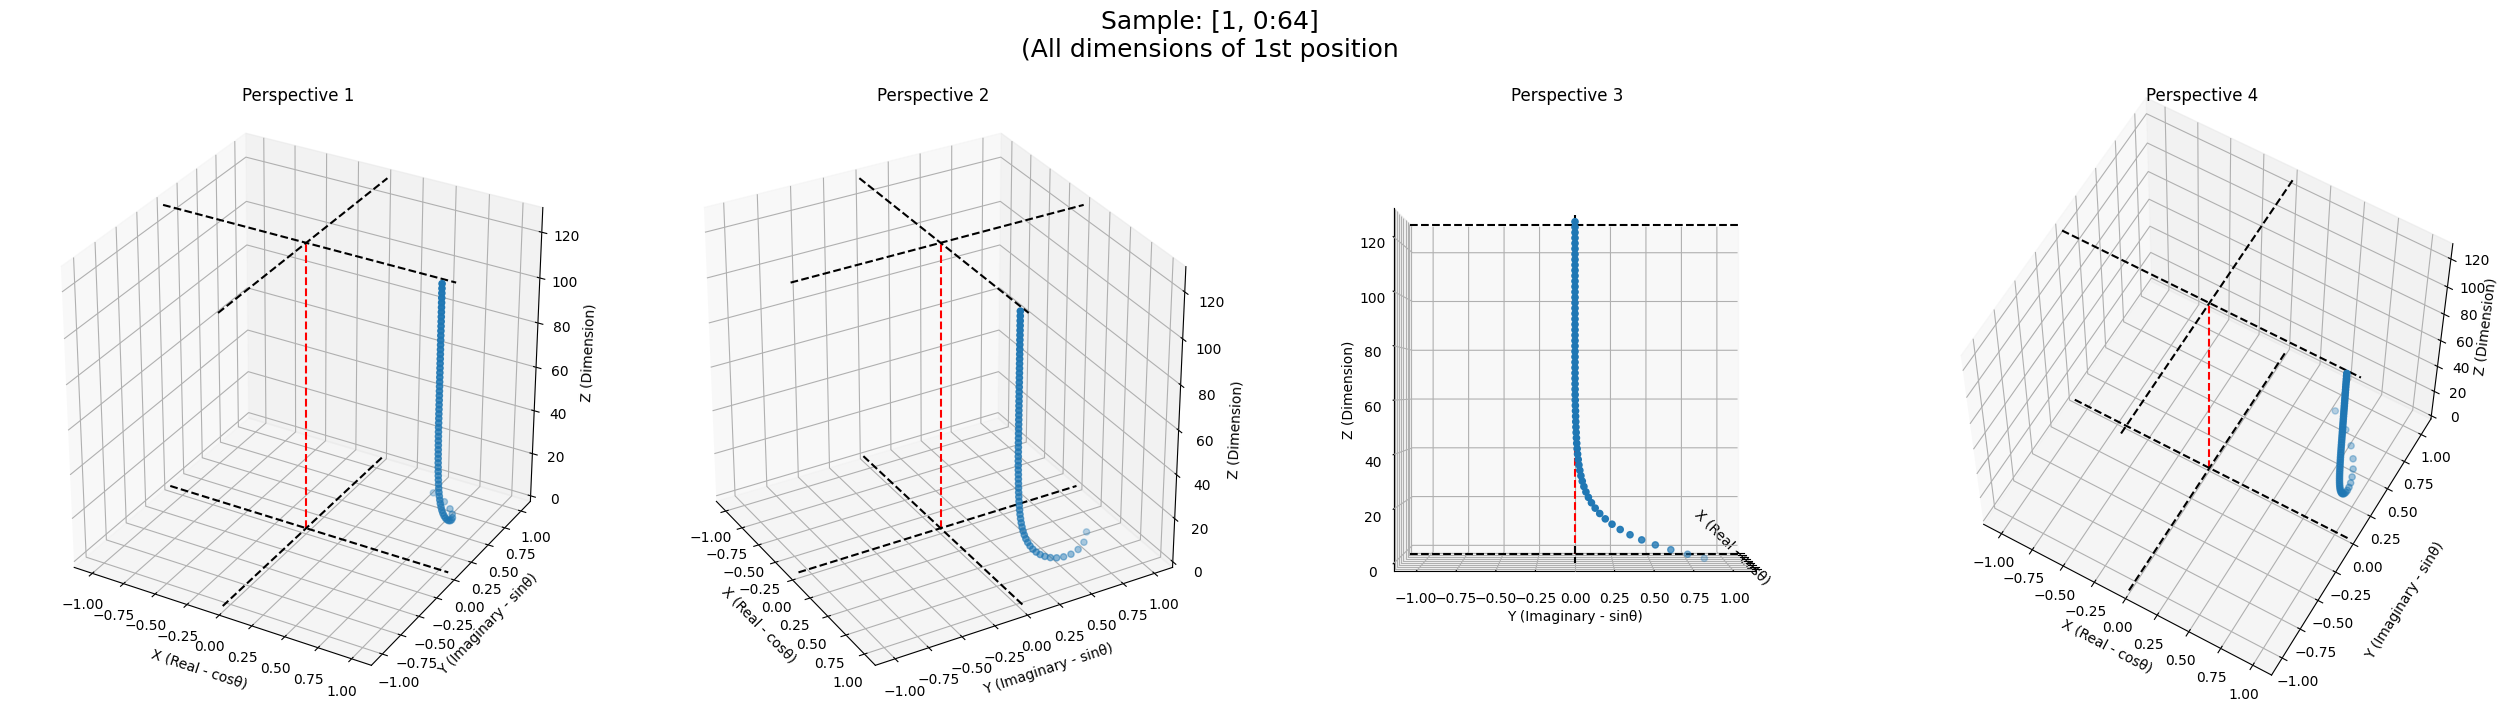

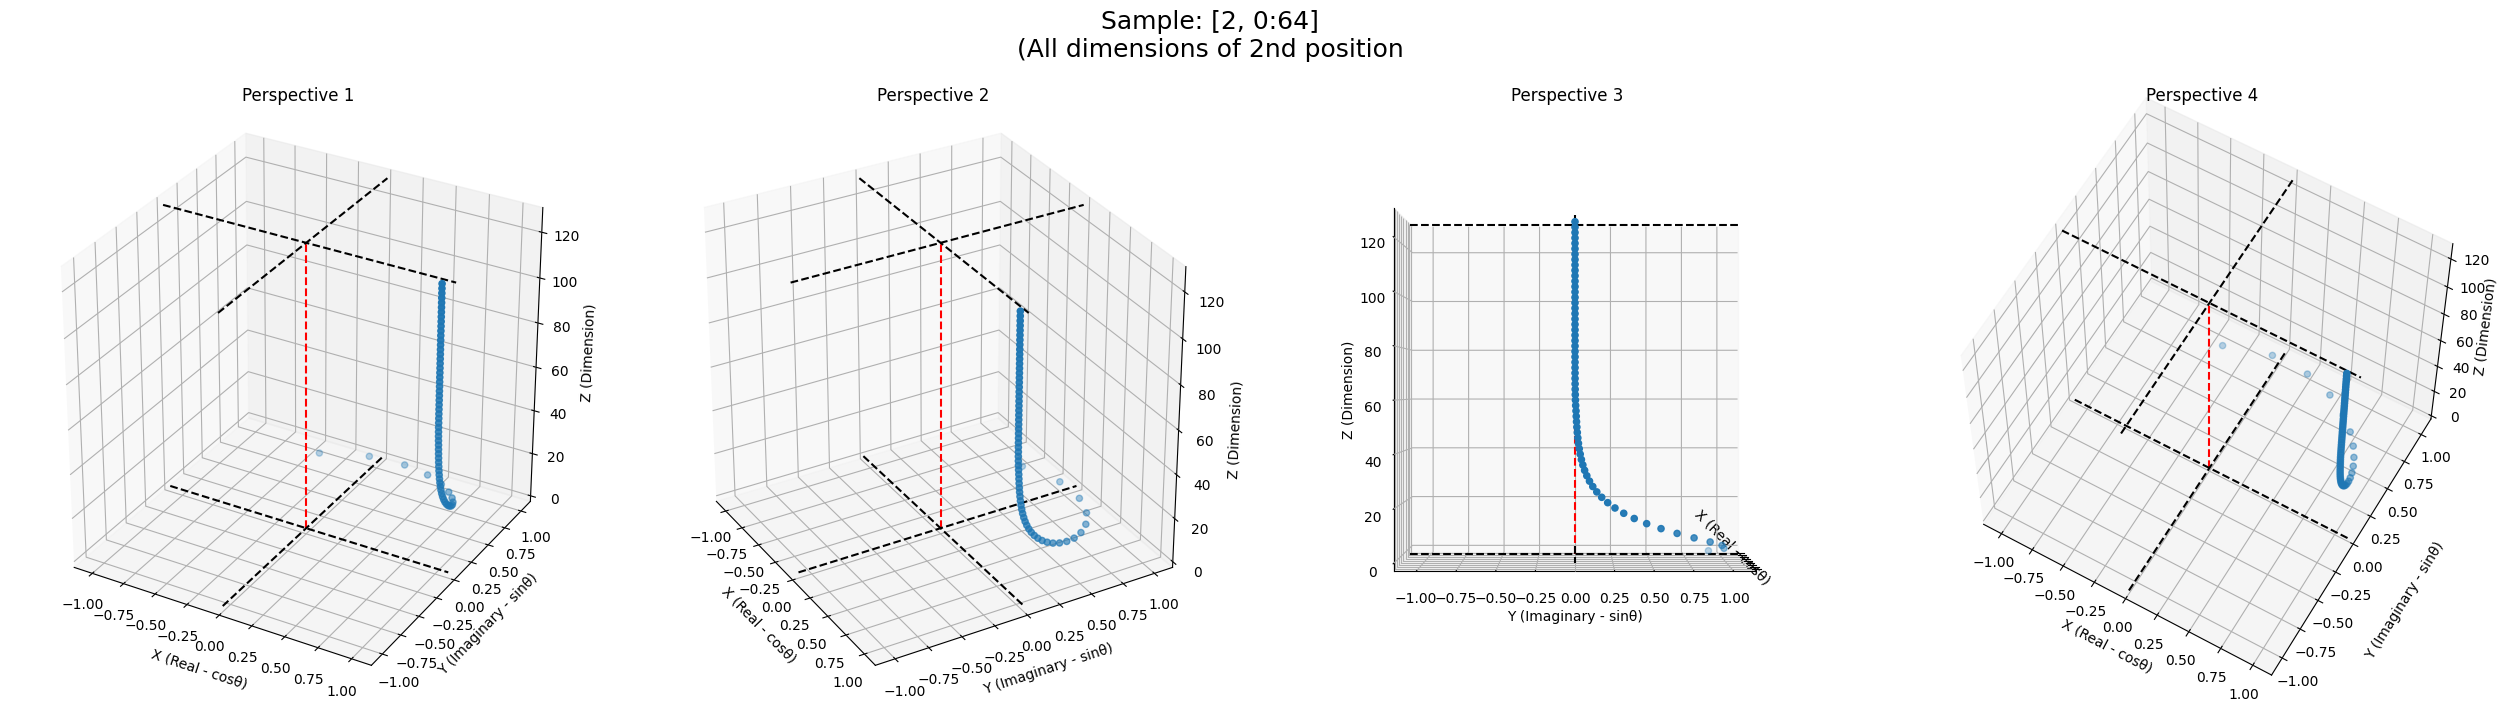

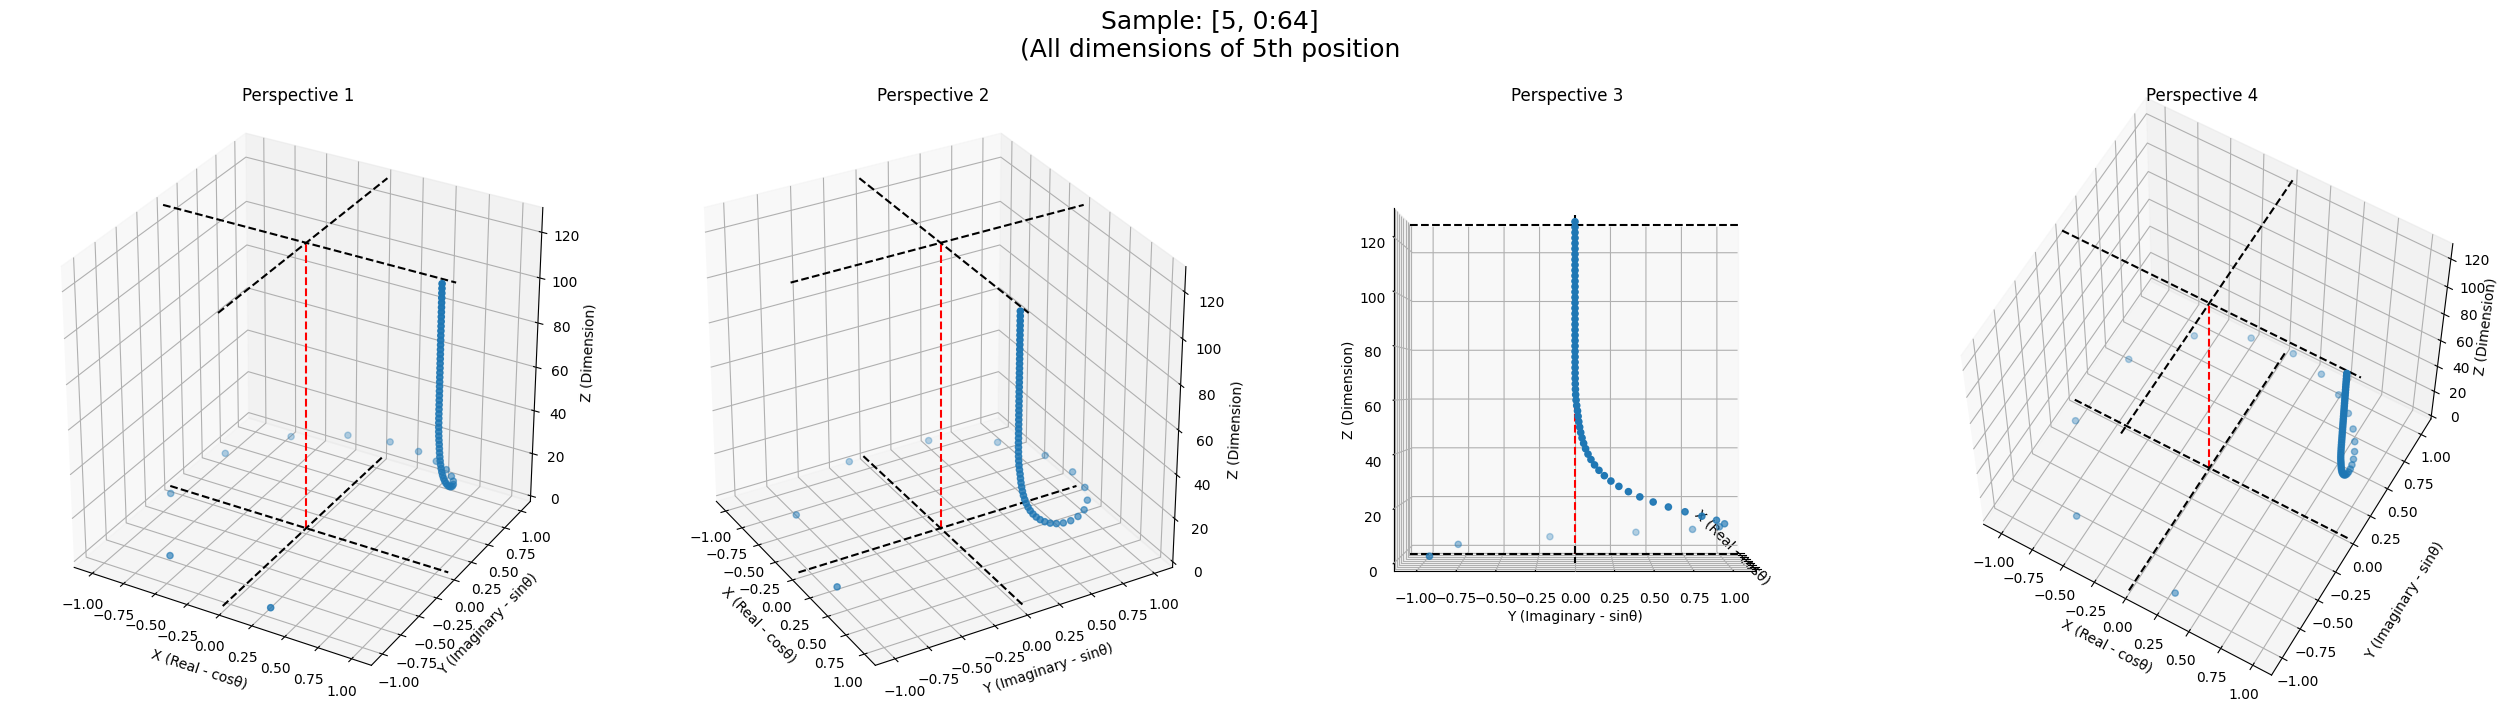

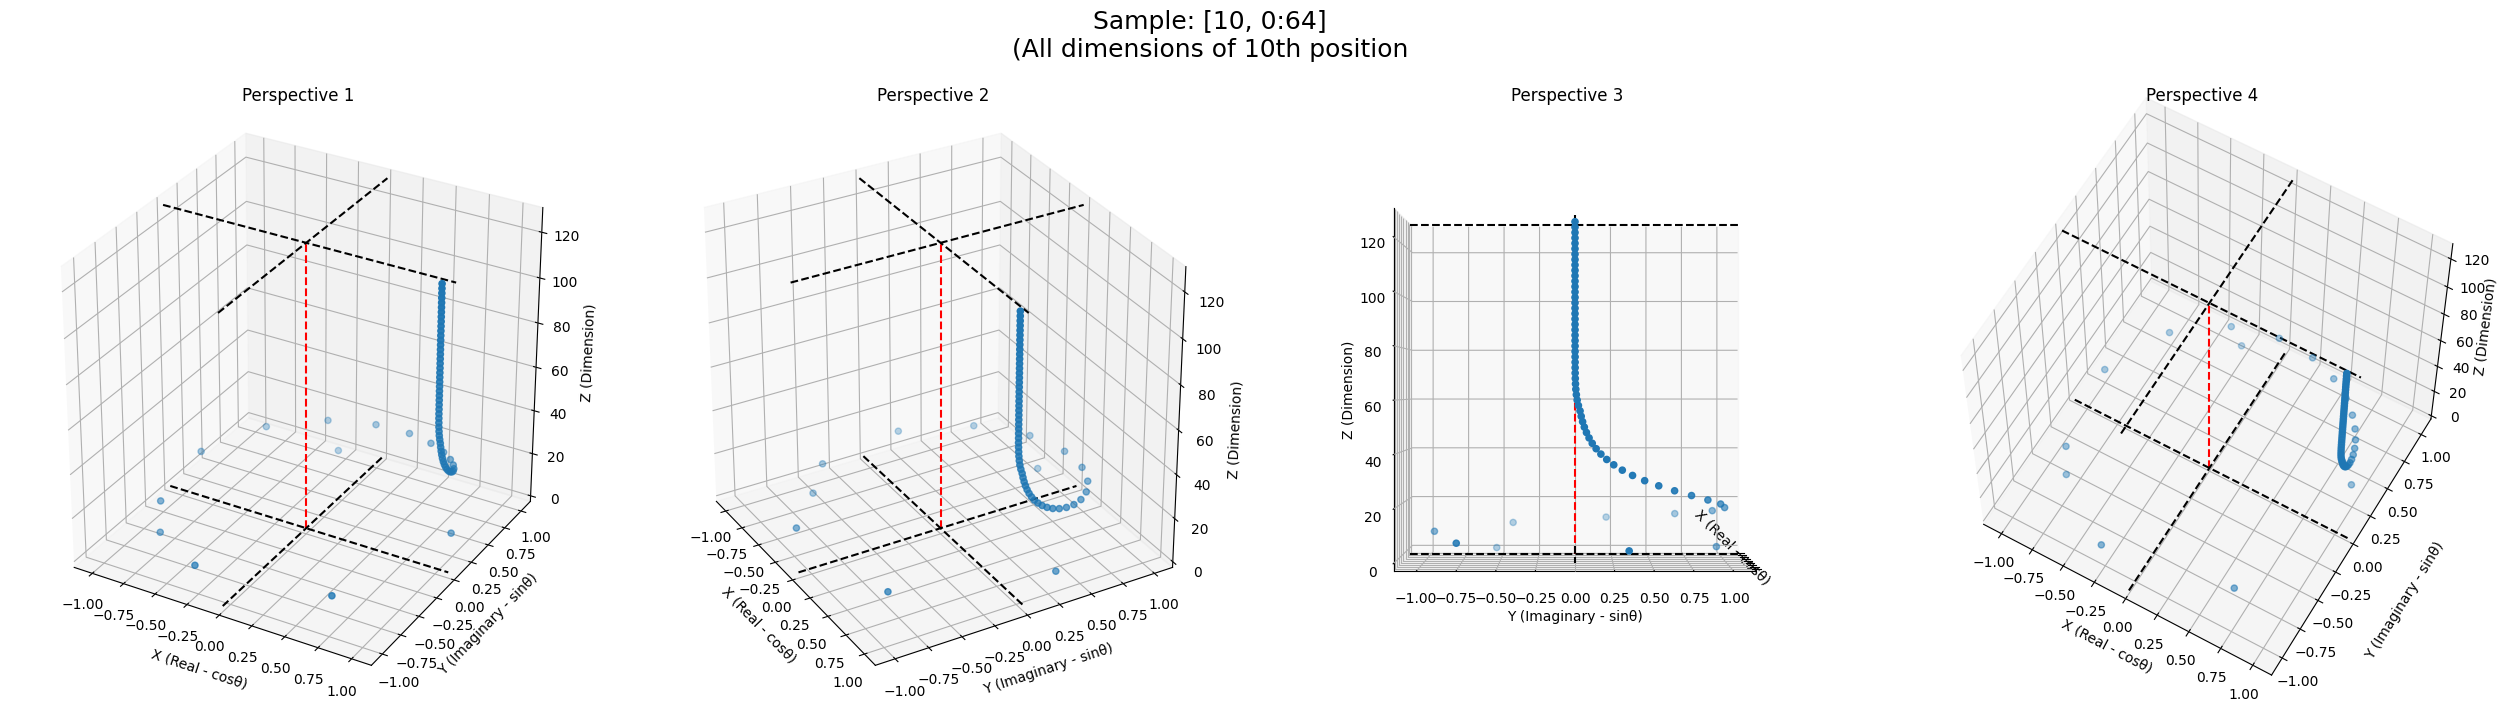

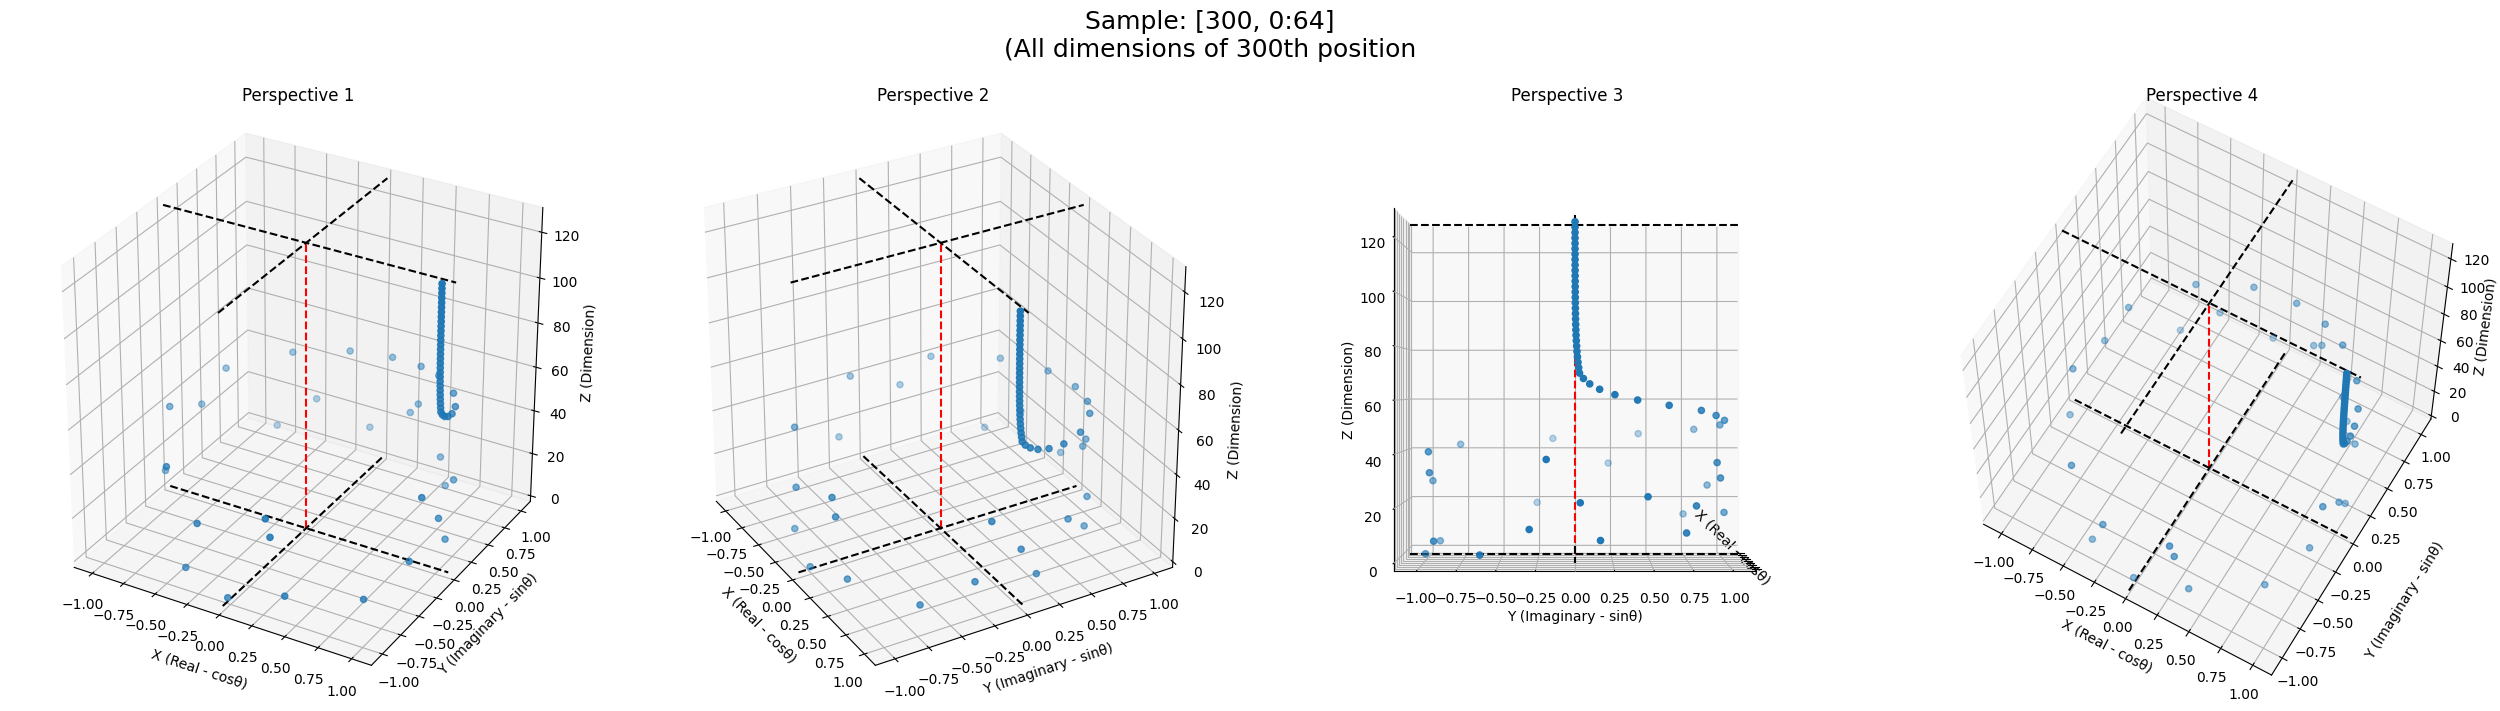

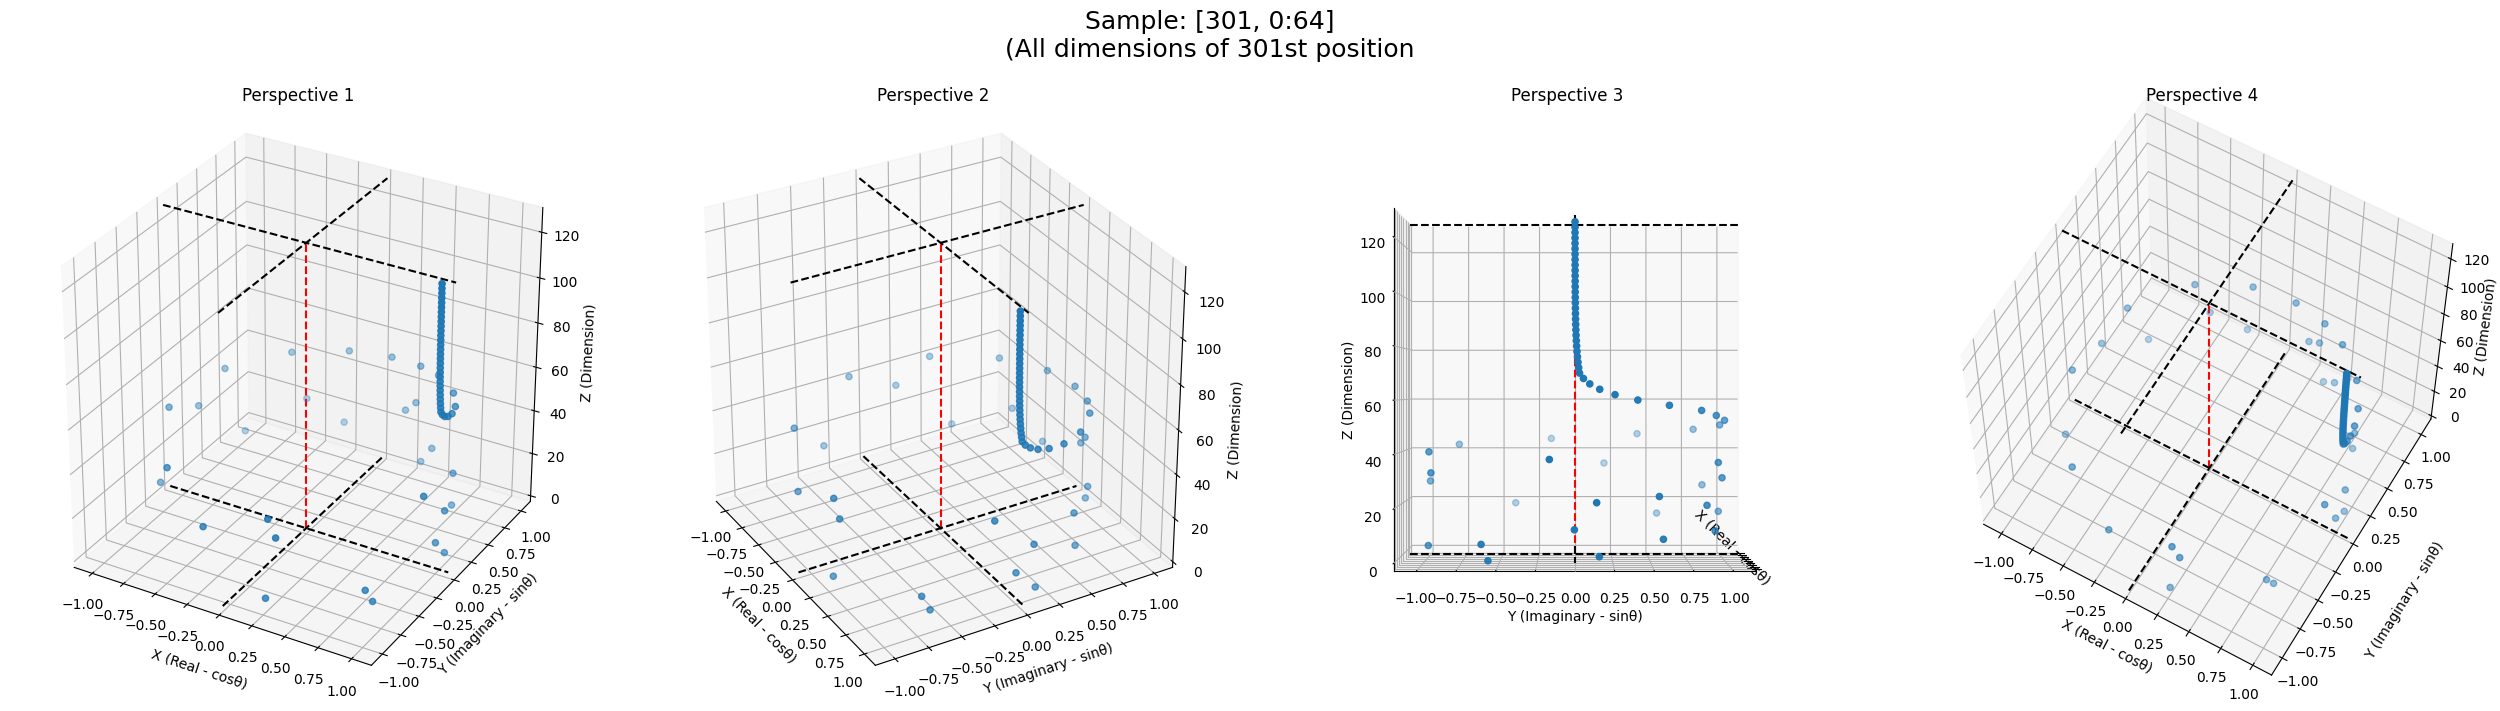

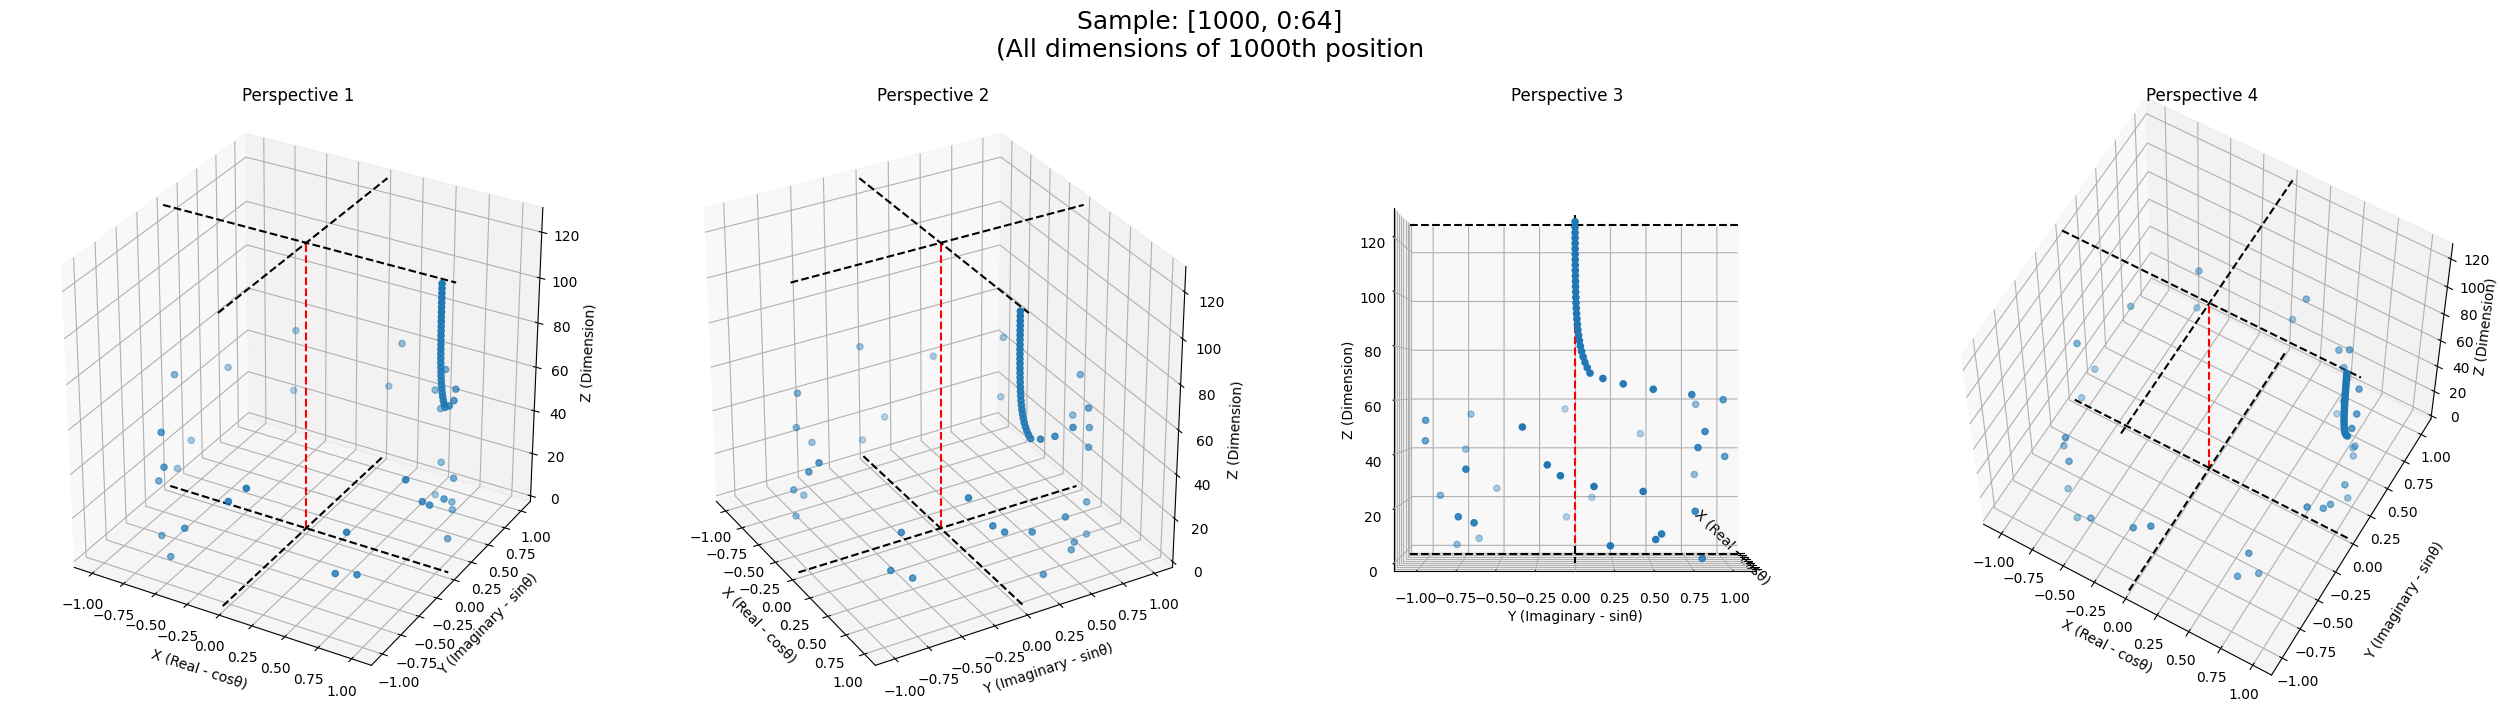

In [17]:
fontsize_figure_title = 18
fontsize_ax_title = 12

def create_3d_fig_multiple(title):
  fig, axs = plt.subplots(1, 4, figsize=(32, 8), subplot_kw={'aspect': 'equal', 'projection': '3d'})
  fig.subplots_adjust(hspace=0.3, wspace=0.1)

  fig.set_facecolor('#FFFFFF')
  fig.suptitle(title, fontsize=fontsize_figure_title)
  return fig, axs

def draw_3d_chart_ax(ax, title, freqs_cis_range, view_init_kwargs=None):
  x = np.real(freqs_cis_range)
  y = np.imag(freqs_cis_range)
  z = vals[0:128]

  xlim = (-1.1, 1.1)
  ylim = (-1.1, 1.1)
  zlim = (0, 128)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_zlim(zlim)

  ax.plot([0, 0], [0, 0], zlim, color='red', linestyle='--')  # x-axis line
  ax.plot([0, 0], ylim, [0, 0], color='black', linestyle='--')  # y-axis line
  ax.plot(xlim, [0, 0], [0, 0], color='black', linestyle='--')  # z-axis line
  ax.plot(xlim, [0, 0], (zlim[1], zlim[1]), color='black', linestyle='--')  # z-axis, lines to roof
  ax.plot([0, 0], ylim, (zlim[1], zlim[1]), color='black', linestyle='--')  # z-axis, lines to roof

  # Change perspective
  if view_init_kwargs is not None:
    ax.view_init(**view_init_kwargs)


  ax.scatter(x, y, z)

  ax.set_xlabel('X (Real - cosθ)')
  ax.set_ylabel('Y (Imaginary - sinθ)')
  ax.set_zlabel('Z (Dimension)')
  ax.set_title(title, fontsize=fontsize_ax_title)

def draw_3d_chart_fig(filename_suffix, title, freqs_cis_range):
  fig, axs = create_3d_fig_multiple(title)
  draw_3d_chart_ax(axs[0], "Perspective 1", freqs_cis_range, None)
  draw_3d_chart_ax(axs[1], "Perspective 2", freqs_cis_range, {'elev':30, 'azim':-30})
  draw_3d_chart_ax(axs[2], "Perspective 3", freqs_cis_range, {'elev':0, 'azim':0})
  axs[2].xaxis.set_ticklabels([])
  axs[2].xaxis.labelpad = -30


  draw_3d_chart_ax(axs[3], "Perspective 4", freqs_cis_range, {'elev':60, 'azim':-60})
  axs[3].yaxis.labelpad = 20
  axs[3].zaxis.labelpad = 0

  save_fig(fig, filename_suffix)
  plt.show()

def draw_all_3d_charts():
  draw_3d_chart_fig("polar_coordinates_3d_pos_0", "Sample: [0, 0:64]\n(All dimensions of 0th position", freqs_cis_orig[0, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_1", "Sample: [1, 0:64]\n(All dimensions of 1st position", freqs_cis_orig[1, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_2", "Sample: [2, 0:64]\n(All dimensions of 2nd position", freqs_cis_orig[2, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_5", "Sample: [5, 0:64]\n(All dimensions of 5th position", freqs_cis_orig[5, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_10", "Sample: [10, 0:64]\n(All dimensions of 10th position", freqs_cis_orig[10, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_300", "Sample: [300, 0:64]\n(All dimensions of 300th position", freqs_cis_orig[300, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_301", "Sample: [301, 0:64]\n(All dimensions of 301st position", freqs_cis_orig[301, 0:64])
  draw_3d_chart_fig("polar_coordinates_3d_pos_1000", "Sample: [1000, 0:64]\n(All dimensions of 1000th position", freqs_cis_orig[1000, 0:64])

draw_all_3d_charts()